# Hangman using HMM-RL Integrated Pipeline

This notebook implements a comprehensive Hangman system that combines:
1. **Hidden Markov Model (HMM)** - Computes probability distributions for language modeling
2. **Reinforcement Learning (RL) Agent** - Uses HMM probabilities to guide guesses

The HMM provides prior knowledge about:
- Valid word distributions
- Character transition probabilities  
- Language patterns

The RL agent leverages these probabilities to make optimal decisions.

## 0. Implementation Roadmap
- Clarify data assets, evaluation needs, and the interplay between HMM prior and RL decision policy.
- Engineer preprocessing utilities: tokenisation, vocabulary, frequency tables, reusable edit-distance helpers.
- Train a character-level HMM on the corpus to estimate `P(letter_t | letter_{t-1})` and word priors; expose scoring and letter-distribution APIs for masked patterns.
- Build a Hangman-style environment that surfaces HMM-derived distributions inside the observation space.
- Design and train a DQN-based agent that consumes environment states and selects letters with an action mask to avoid repeats.
- Evaluate the joint pipeline on held-out Hangman games crafted from `test.txt`, reporting win rate, mean guesses, and error analysis.


## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter, deque
import re
import string
import random
from typing import List, Dict, Tuple, Set, Optional
import itertools
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

def device() -> torch.device:
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Data

In [2]:
# Load corpus (training data - correct words)
with open('Data/corpus.txt', 'r', encoding='utf-8') as f:
    corpus_words = [line.strip().lower() for line in f if line.strip()]

# Load test data (potentially misspelled words to correct)
with open('Data/test.txt', 'r', encoding='utf-8') as f:
    test_words = [line.strip().lower() for line in f if line.strip()]

print(f"Corpus size: {len(corpus_words)} words")
print(f"Test size: {len(test_words)} words")
print(f"\nFirst 10 corpus words: {corpus_words[:10]}")
print(f"First 10 test words: {test_words[:10]}")

Corpus size: 50000 words
Test size: 2000 words

First 10 corpus words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
First 10 test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


## 3. Build Vocabulary and Character Mappings

In [3]:
# Build vocabulary with word frequencies
word_freq = Counter(corpus_words)
vocabulary = set(corpus_words)

# Alphabet baseline (lowercase letters only)
alphabet = list(string.ascii_lowercase)
alphabet_index = {char: idx for idx, char in enumerate(alphabet)}
BLANK_SYMBOL = '_'
BLANK_INDEX = len(alphabet)

# Extract all unique characters from corpus (fallback to alphabet if needed)
all_chars = sorted(set(''.join(corpus_words)) | set(alphabet))
char_to_idx = {char: idx for idx, char in enumerate(all_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Add special boundary tokens for HMM transitions
start_token = '<START>'
end_token = '<END>'
char_to_idx[start_token] = len(char_to_idx)
char_to_idx[end_token] = len(char_to_idx)
idx_to_char[char_to_idx[start_token]] = start_token
idx_to_char[char_to_idx[end_token]] = end_token

print(f"Vocabulary size: {len(vocabulary)} unique words")
print(f"Character set size: {len(char_to_idx)} characters (including boundaries)")
print(f"Characters: {all_chars}")
print("\nMost common words:")
for word, count in word_freq.most_common(10):
    print(f"  {word}: {count}")

Vocabulary size: 49398 unique words
Character set size: 29 characters (including boundaries)
Characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Most common words:
  gato: 26
  nein: 22
  noche: 21
  au revoir: 21
  obrigado: 20
  chat: 19
  bonjour: 18
  prego: 18
  fromage: 18
  bueno: 18


## 4.1 Corpus Indexes for Efficient Lookup

In [4]:
# Pre-compute helper structures for quick filtering
words_by_length: Dict[int, List[Tuple[str, int]]] = defaultdict(list)
for word, freq in word_freq.items():
    words_by_length[len(word)].append((word, freq))

max_word_length = max(len(word) for word in vocabulary)
min_word_length = min(len(word) for word in vocabulary)

print(f"Min word length: {min_word_length}")
print(f"Max word length: {max_word_length}")
print(f"Average word length: {np.mean([len(w) for w in corpus_words]):.2f}")

Min word length: 1
Max word length: 24
Average word length: 9.50


## 5. Hidden Markov Model (HMM) Training

In [6]:
class CharacterHMM:
    """Character-level HMM with start/end boundary tokens and Viterbi decoding support."""

    def __init__(self,
                 char_to_idx: Dict[str, int],
                 alphabet: List[str],
                 alphabet_index: Dict[str, int],
                 words_by_length: Dict[int, List[Tuple[str, int]]],
                 start_token: str = '<START>',
                 end_token: str = '<END>',
                 smoothing: float = 1e-2):
        self.char_to_idx = char_to_idx
        self.idx_to_char = {idx: char for char, idx in char_to_idx.items()}
        self.start_token = start_token
        self.end_token = end_token
        self.smoothing = smoothing
        self.n_chars = len(char_to_idx)
        self.transition_log_probs: Optional[np.ndarray] = None
        self.initial_log_probs: Optional[np.ndarray] = None
        self.alphabet = alphabet
        self.alphabet_index = alphabet_index
        self.words_by_length = words_by_length

    def fit(self, word_freq: Counter) -> None:
        transition_counts = np.full((self.n_chars, self.n_chars), self.smoothing, dtype=np.float64)
        initial_counts = np.full(self.n_chars, self.smoothing, dtype=np.float64)

        start_idx = self.char_to_idx[self.start_token]
        end_idx = self.char_to_idx[self.end_token]

        for word, freq in word_freq.items():
            if not word:
                continue
            prev_idx = start_idx
            first_idx = self.char_to_idx.get(word[0])
            if first_idx is not None:
                initial_counts[first_idx] += freq
            for char in word:
                curr_idx = self.char_to_idx.get(char)
                if curr_idx is None:
                    continue
                transition_counts[prev_idx, curr_idx] += freq
                prev_idx = curr_idx
            transition_counts[prev_idx, end_idx] += freq

        transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
        initial_probs = initial_counts / initial_counts.sum()

        self.transition_log_probs = np.log(transition_probs)
        self.initial_log_probs = np.log(initial_probs)

    def score_word(self, word: str) -> float:
        if self.transition_log_probs is None or self.initial_log_probs is None:
            raise RuntimeError("HMM must be fitted before scoring words.")
        if not word:
            return float('-inf')

        log_prob = 0.0
        first_idx = self.char_to_idx.get(word[0])
        if first_idx is None:
            return float('-inf')
        log_prob += self.initial_log_probs[first_idx]
        prev_idx = self.char_to_idx[self.start_token]
        for char in word:
            curr_idx = self.char_to_idx.get(char)
            if curr_idx is None:
                return float('-inf')
            log_prob += self.transition_log_probs[prev_idx, curr_idx]
            prev_idx = curr_idx
        log_prob += self.transition_log_probs[prev_idx, self.char_to_idx[self.end_token]]
        return log_prob

    def logsumexp(self, log_values: np.ndarray) -> float:
        max_val = np.max(log_values)
        return max_val + np.log(np.sum(np.exp(log_values - max_val)))

    def viterbi_decode_pattern(self, pattern: str, guessed: Set[str]) -> Tuple[str, float]:
        """Decode the most probable word consistent with pattern & guessed letters."""
        if self.transition_log_probs is None or self.initial_log_probs is None:
            raise RuntimeError("HMM must be fitted before Viterbi decoding.")

        pattern = pattern.lower()
        length = len(pattern)
        if length == 0:
            return '', float('-inf')

        wrong_letters = {char for char in guessed if char not in pattern}
        allowed_base = [c for c in self.alphabet if c not in wrong_letters] or list(self.alphabet)
        allowed_letters = []
        for ch in pattern:
            if ch == '_':
                allowed_letters.append(allowed_base)
            else:
                allowed_letters.append([ch])

        start_idx = self.char_to_idx[self.start_token]
        end_idx = self.char_to_idx[self.end_token]
        n_letters = len(self.alphabet)
        dp = np.full((length, n_letters), -np.inf, dtype=np.float64)
        backpointers = np.full((length, n_letters), -1, dtype=np.int32)

        # Initialise first position
        for letter in allowed_letters[0]:
            if letter not in self.alphabet_index:
                continue
            char_idx = self.char_to_idx.get(letter)
            if char_idx is None:
                continue
            col_idx = self.alphabet_index[letter]
            dp[0, col_idx] = self.initial_log_probs[char_idx] + self.transition_log_probs[start_idx, char_idx]

        # Dynamic programming for remaining positions
        for pos in range(1, length):
            for letter in allowed_letters[pos]:
                if letter not in self.alphabet_index:
                    continue
                curr_idx = self.char_to_idx.get(letter)
                if curr_idx is None:
                    continue
                curr_col = self.alphabet_index[letter]
                best_prev_score = -np.inf
                best_prev_col = -1
                for prev_letter in allowed_letters[pos - 1]:
                    if prev_letter not in self.alphabet_index:
                        continue
                    prev_col = self.alphabet_index[prev_letter]
                    prev_idx = self.char_to_idx.get(prev_letter)
                    prev_score = dp[pos - 1, prev_col]
                    if np.isneginf(prev_score) or prev_idx is None:
                        continue
                    score = prev_score + self.transition_log_probs[prev_idx, curr_idx]
                    if score > best_prev_score:
                        best_prev_score = score
                        best_prev_col = prev_col
                if not np.isneginf(best_prev_score):
                    dp[pos, curr_col] = best_prev_score
                    backpointers[pos, curr_col] = best_prev_col

        # Termination
        best_score = -np.inf
        best_last_col = -1
        for letter in allowed_letters[-1]:
            if letter not in self.alphabet_index:
                continue
            letter_col = self.alphabet_index[letter]
            letter_idx = self.char_to_idx.get(letter)
            path_score = dp[length - 1, letter_col]
            if np.isneginf(path_score) or letter_idx is None:
                continue
            total_score = path_score + self.transition_log_probs[letter_idx, end_idx]
            if total_score > best_score:
                best_score = total_score
                best_last_col = letter_col

        if best_last_col == -1:
            return '', float('-inf')

        sequence = [''] * length
        current_col = best_last_col
        for pos in range(length - 1, -1, -1):
            if current_col < 0:
                return '', float('-inf')
            sequence[pos] = self.alphabet[current_col]
            if pos > 0:
                current_col = backpointers[pos, current_col]

        return ''.join(sequence), best_score

    def letter_distribution(self, pattern: str, guessed: Set[str]) -> np.ndarray:
        """Return probability distribution over alphabet for missing spots."""
        pattern = pattern.lower()
        length = len(pattern)
        alphabet_regex = '[' + re.escape(''.join(self.alphabet)) + ']'
        regex_pattern = '^' + ''.join([ch if ch != '_' else alphabet_regex for ch in pattern]) + '$'
        regex = re.compile(regex_pattern)
        candidates: List[Tuple[str, float]] = []

        wrong_letters = {char for char in guessed if char not in pattern}

        for candidate, freq in self.words_by_length.get(length, []):
            if regex.match(candidate) and not any(char in wrong_letters for char in candidate):
                candidates.append((candidate, float(freq)))

        if not candidates:
            viterbi_word, _ = self.viterbi_decode_pattern(pattern, guessed)
            if viterbi_word:
                if not any(existing == viterbi_word for existing, _ in candidates):
                    candidates.append((viterbi_word, 1.0))

        if not candidates:
            dist = np.zeros(len(self.alphabet), dtype=np.float64)
            remaining = [idx for idx, char in enumerate(self.alphabet) if char not in guessed]
            if remaining:
                uniform_val = 1.0 / len(remaining)
                for idx in remaining:
                    dist[idx] = uniform_val
            return dist

        log_weights = []
        for word, freq in candidates:
            word_score = self.score_word(word)
            log_weight = word_score + np.log(freq + 1e-6)
            log_weights.append(log_weight)
        log_weights = np.array(log_weights, dtype=np.float64)
        normaliser = self.logsumexp(log_weights)
        probs = np.exp(log_weights - normaliser)

        letter_scores = np.zeros(len(self.alphabet), dtype=np.float64)
        for (word, _), weight in zip(candidates, probs):
            for char in set(word):
                if char in guessed:
                    continue
                if char not in self.alphabet_index:
                    continue
                idx = self.alphabet_index[char]
                letter_scores[idx] += weight * word.count(char)

        total = letter_scores.sum()
        if total <= 0:
            remaining = [idx for idx, char in enumerate(self.alphabet) if char not in guessed]
            if remaining:
                uniform_val = 1.0 / len(remaining)
                for idx in remaining:
                    letter_scores[idx] = uniform_val
            return letter_scores

        letter_scores /= total
        return letter_scores

### 5.1 Fit HMM on Corpus

In [7]:
hmm = CharacterHMM(
    char_to_idx=char_to_idx,
    alphabet=alphabet,
    alphabet_index=alphabet_index,
    words_by_length=words_by_length,
    start_token=start_token,
    end_token=end_token,
    smoothing=1e-2
 )
hmm.fit(word_freq)

sample_words = random.sample(corpus_words, k=5)
for w in sample_words:
    print(f"Word: {w:>12} | Log-probability: {hmm.score_word(w):.2f}")

Word: humanitarianize | Log-probability: -40.89
Word:     portulan | Log-probability: -24.02
Word:       camata | Log-probability: -18.98
Word:  intromitter | Log-probability: -31.28
Word:    segmented | Log-probability: -28.02


### 5.2 HMM-Informed Letter Distributions

In [8]:
def display_letter_distribution(pattern: str, guessed: Set[str]) -> None:
    distribution = hmm.letter_distribution(pattern, guessed)
    top_indices = np.argsort(distribution)[::-1][:5]
    print(f"Pattern: {pattern} | Guessed: {sorted(guessed)}")
    for idx in top_indices:
        print(f"  Letter '{alphabet[idx]}': {distribution[idx]:.3f}")

# Demo patterns
patterns = ['_____','a____','__a_e','c_t']
guessed_sets = [set(), {'a'}, {'a', 'e', 's'}, {'c', 't'}]

for pat, guessed in zip(patterns, guessed_sets):
    display_letter_distribution(pat, guessed)
    print('-' * 40)

Pattern: _____ | Guessed: []
  Letter 'e': 0.140
  Letter 'a': 0.109
  Letter 'r': 0.086
  Letter 's': 0.080
  Letter 't': 0.079
----------------------------------------
Pattern: a____ | Guessed: ['a']
  Letter 'e': 0.167
  Letter 'l': 0.125
  Letter 'i': 0.118
  Letter 'n': 0.106
  Letter 'r': 0.070
----------------------------------------
Pattern: __a_e | Guessed: ['a', 'e', 's']
  Letter 'r': 0.289
  Letter 't': 0.210
  Letter 'p': 0.138
  Letter 'c': 0.123
  Letter 'h': 0.049
----------------------------------------
Pattern: c_t | Guessed: ['c', 't']
  Letter 'o': 1.000
  Letter 'z': 0.000
  Letter 'x': 0.000
  Letter 'w': 0.000
  Letter 'v': 0.000
----------------------------------------


## 6. Hangman Environment Leveraging HMM Guidance

### 6.1 Train / Evaluation Pools

In [9]:
# Split corpus into train/eval pools for Hangman episodes
unique_corpus_words = list(vocabulary)
random.shuffle(unique_corpus_words)
split_idx = int(0.9 * len(unique_corpus_words))
train_words = unique_corpus_words[:split_idx]
eval_words = unique_corpus_words[split_idx:]

print(f"Training words pool: {len(train_words)}")
print(f"Evaluation words pool: {len(eval_words)}")

Training words pool: 44458
Evaluation words pool: 4940


In [14]:
MAX_PATTERN_LENGTH = min(20, max_word_length)


def encode_pattern_indices(pattern: str) -> np.ndarray:
    """Encode pattern into fixed-length indices with BLANK_INDEX for unknown slots."""
    encoded = np.full(MAX_PATTERN_LENGTH, BLANK_INDEX, dtype=np.int64)
    for idx, char in enumerate(pattern[:MAX_PATTERN_LENGTH]):
        if char != '_' and char in alphabet_index:
            encoded[idx] = alphabet_index[char]
    return encoded


def encode_guessed(guessed: Set[str]) -> np.ndarray:
    vec = np.zeros(len(alphabet), dtype=np.float32)
    for char in guessed:
        if char in alphabet_index:
            vec[alphabet_index[char]] = 1.0
    return vec


class HangmanEnv:
    def __init__(self, words: List[str], hmm_model: "CharacterHMM", max_lives: int = 6):
        self.words = words
        self.hmm_model = hmm_model
        self.max_lives = max_lives
        self.current_word = ''
        self.pattern: List[str] = []
        self.guessed_letters: Set[str] = set()
        self.remaining_lives = max_lives

    def reset(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        self.current_word = random.choice(self.words)
        self.pattern = ['_'] * len(self.current_word)
        self.guessed_letters = set()
        self.remaining_lives = self.max_lives
        return self._get_observation()

    def _pattern_str(self) -> str:
        return ''.join(self.pattern)

    def _get_observation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        pattern_indices = encode_pattern_indices(self._pattern_str())
        guessed_vector = encode_guessed(self.guessed_letters)
        hmm_distribution = self.hmm_model.letter_distribution(self._pattern_str(), self.guessed_letters)
        lives_scalar = np.array([self.remaining_lives / self.max_lives], dtype=np.float32)
        return (
            pattern_indices.copy(),
            guessed_vector.astype(np.float32, copy=False),
            np.asarray(hmm_distribution, dtype=np.float32),
            lives_scalar.copy(),
        )

    def step(self, action_idx: int) -> Tuple[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], float, bool, Dict]:
        letter = alphabet[action_idx]
        info = {'letter': letter}

        if letter in self.guessed_letters:
            reward = -2.0
            done = False
            info['repeat'] = True
            info['correct'] = False
            return self._get_observation(), reward, done, info

        self.guessed_letters.add(letter)
        occurrences = [idx for idx, char in enumerate(self.current_word) if char == letter]

        if occurrences:
            for idx in occurrences:
                self.pattern[idx] = letter
            reward = 1.5 * len(occurrences)
            info['correct'] = True
            done = False
            if '_' not in self.pattern:
                reward += 10.0
                done = True
                info['completed'] = True
        else:
            self.remaining_lives -= 1
            reward = -1.5
            info['correct'] = False
            done = self.remaining_lives <= 0
            if done:
                reward -= 5.0
                info['failed'] = True

        if done:
            info['target_word'] = self.current_word

        return self._get_observation(), reward, done, info

    def action_mask(self) -> np.ndarray:
        mask = np.ones(len(alphabet), dtype=np.float32)
        for letter in self.guessed_letters:
            if letter in alphabet_index:
                mask[alphabet_index[letter]] = 0.0
        return mask

    def render(self) -> None:
        print(f"Word: {' '.join(self.pattern)} | Lives: {self.remaining_lives} | Guessed: {sorted(self.guessed_letters)}")

## 7. Reinforcement Learning Agent (DQN)

In [15]:
ACTION_DIM = len(alphabet)


class ReplayBuffer:
    def __init__(self, capacity: int = 50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, mask):
        stored_state = (
            np.array(state[0], dtype=np.int64, copy=True),
            np.array(state[1], dtype=np.float32, copy=True),
            np.array(state[2], dtype=np.float32, copy=True),
            np.array(state[3], dtype=np.float32, copy=True),
        )
        stored_next_state = (
            np.array(next_state[0], dtype=np.int64, copy=True),
            np.array(next_state[1], dtype=np.float32, copy=True),
            np.array(next_state[2], dtype=np.float32, copy=True),
            np.array(next_state[3], dtype=np.float32, copy=True),
        )
        self.buffer.append((stored_state, action, reward, stored_next_state, done, np.array(mask, dtype=np.float32, copy=True)))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones, masks = zip(*batch)

        def stack_state(state_components):
            patterns = np.stack([s[0] for s in state_components], axis=0)
            guessed = np.stack([s[1] for s in state_components], axis=0)
            hmm_dists = np.stack([s[2] for s in state_components], axis=0)
            lives = np.stack([s[3] for s in state_components], axis=0)
            return patterns, guessed, hmm_dists, lives

        return (
            stack_state(states),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            stack_state(next_states),
            np.array(dones, dtype=np.float32),
            np.stack(masks).astype(np.float32)
        )

    def __len__(self):
        return len(self.buffer)


CHAR_EMBEDDING_DIM = 16
PATTERN_CHANNELS = 64


class EnhancedDQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(alphabet) + 1, CHAR_EMBEDDING_DIM)
        self.pattern_cnn = nn.Sequential(
            nn.Conv1d(CHAR_EMBEDDING_DIM, PATTERN_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(PATTERN_CHANNELS, PATTERN_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pattern_pool = nn.AdaptiveMaxPool1d(1)
        combined_input_dim = PATTERN_CHANNELS + len(alphabet) * 2 + 1
        self.mlp = nn.Sequential(
            nn.Linear(combined_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, ACTION_DIM)
        )

    def forward(self, pattern_indices, guessed_vec, hmm_dist, lives_scalar):
        x = self.embedding(pattern_indices)
        x = x.permute(0, 2, 1)
        x = self.pattern_cnn(x)
        x = self.pattern_pool(x).squeeze(-1)
        combined = torch.cat([x, guessed_vec, hmm_dist, lives_scalar], dim=1)
        return self.mlp(combined)


class DQNAgent:
    def __init__(self, action_dim: int, lr: float = 1e-3, gamma: float = 0.99):
        self.action_dim = action_dim
        self.gamma = gamma
        self._device = device()
        self.policy_net = EnhancedDQN().to(self._device)
        self.target_net = EnhancedDQN().to(self._device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.steps_done = 0

    def _state_to_tensors(self, state):
        pattern_tensor = torch.tensor(state[0], dtype=torch.long, device=self._device).unsqueeze(0)
        guessed_tensor = torch.tensor(state[1], dtype=torch.float32, device=self._device).unsqueeze(0)
        hmm_tensor = torch.tensor(state[2], dtype=torch.float32, device=self._device).unsqueeze(0)
        lives_tensor = torch.tensor(state[3], dtype=torch.float32, device=self._device).unsqueeze(0)
        return pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor

    def _batch_to_tensors(self, batch_state):
        patterns, guessed, hmm_dist, lives = batch_state
        pattern_tensor = torch.tensor(patterns, dtype=torch.long, device=self._device)
        guessed_tensor = torch.tensor(guessed, dtype=torch.float32, device=self._device)
        hmm_tensor = torch.tensor(hmm_dist, dtype=torch.float32, device=self._device)
        lives_tensor = torch.tensor(lives, dtype=torch.float32, device=self._device)
        return pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor

    def select_action(self, state, action_mask: np.ndarray, epsilon: float) -> int:
        if random.random() < epsilon:
            available_indices = np.where(action_mask > 0)[0]
            if len(available_indices) == 0:
                return int(random.randrange(self.action_dim))
            return int(random.choice(available_indices))

        pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor = self._state_to_tensors(state)
        with torch.no_grad():
            q_values = self.policy_net(pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor).squeeze(0).cpu().numpy()
        masked_q = np.where(action_mask > 0, q_values, -np.inf)
        return int(np.argmax(masked_q))

    def update(self, batch):
        (state_patterns, state_guessed, state_hmm, state_lives), actions, rewards, (next_patterns, next_guessed, next_hmm, next_lives), dones, masks = batch

        pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor = self._batch_to_tensors((state_patterns, state_guessed, state_hmm, state_lives))
        next_pattern_tensor, next_guessed_tensor, next_hmm_tensor, next_lives_tensor = self._batch_to_tensors((next_patterns, next_guessed, next_hmm, next_lives))

        actions_tensor = torch.tensor(actions, dtype=torch.long, device=self._device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=self._device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32, device=self._device)
        masks_tensor = torch.tensor(masks, dtype=torch.float32, device=self._device)

        q_values = self.policy_net(pattern_tensor, guessed_tensor, hmm_tensor, lives_tensor)
        state_action_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_net(next_pattern_tensor, next_guessed_tensor, next_hmm_tensor, next_lives_tensor)
            penalised_next = next_q_values.masked_fill(masks_tensor <= 0, -1e9)
            max_next_q_values = penalised_next.max(dim=1).values
            expected_values = rewards_tensor + self.gamma * (1 - dones_tensor) * max_next_q_values

        loss = nn.functional.mse_loss(state_action_values, expected_values)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        return float(loss.item())

    def soft_update(self, tau: float = 0.01):
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

### 7.1 Training Loop & Hyperparameters

In [16]:
def train_dqn(env: HangmanEnv,
              agent: DQNAgent,
              episodes: int = 800,
              batch_size: int = 64,
              buffer_capacity: int = 80000,
              epsilon_start: float = 1.0,
              epsilon_end: float = 0.05,
              epsilon_decay: float = 0.995,
              target_update_tau: float = 0.01,
              min_buffer_size: int = 5000) -> Dict[str, List[float]]:
    replay_buffer = ReplayBuffer(capacity=buffer_capacity)
    epsilon = epsilon_start
    rewards_history: List[float] = []
    losses_history: List[float] = []
    win_rates: List[float] = []
    episode_successes: List[int] = []

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        mask = env.action_mask()
        episode_reward = 0.0
        done = False
        last_info: Dict = {}

        while not done:
            action = agent.select_action(state, mask, epsilon)
            next_state, reward, done, info = env.step(action)
            next_mask = env.action_mask()

            replay_buffer.push(state, action, reward, next_state, float(done), next_mask)
            state = next_state
            mask = next_mask
            episode_reward += reward
            last_info = info

            if len(replay_buffer) >= max(batch_size, min_buffer_size):
                batch = replay_buffer.sample(batch_size)
                loss = agent.update(batch)
                losses_history.append(loss)
                agent.soft_update(target_update_tau)

        rewards_history.append(episode_reward)
        episode_successes.append(1 if last_info.get('completed', False) else 0)

        if episode % 20 == 0:
            recent_successes = episode_successes[-20:]
            if recent_successes:
                win_rates.append(sum(recent_successes) / len(recent_successes))
            else:
                win_rates.append(0.0)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

    return {
        'rewards': rewards_history,
        'losses': losses_history,
        'win_rates': win_rates
    }

### 7.2 Warm-Up Training Run (Adjustable)

In [17]:
RUN_TRAINING = True  # flip to True to launch a training session
NUM_EPISODES = 300

hangman_env = HangmanEnv(train_words, hmm, max_lives=6)
dqn_agent = DQNAgent(action_dim=ACTION_DIM, lr=5e-4, gamma=0.98)

training_stats = None
if RUN_TRAINING:
    training_stats = train_dqn(
        env=hangman_env,
        agent=dqn_agent,
        episodes=NUM_EPISODES,
        batch_size=128,
        buffer_capacity=100000,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        target_update_tau=0.02,
        min_buffer_size=3000
    )
    print("Training complete!")
else:
    print("Training skipped. Set RUN_TRAINING=True to start training.")

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:27<00:00, 10.72it/s]

Training complete!


### 7.3 Visualising Training Progress

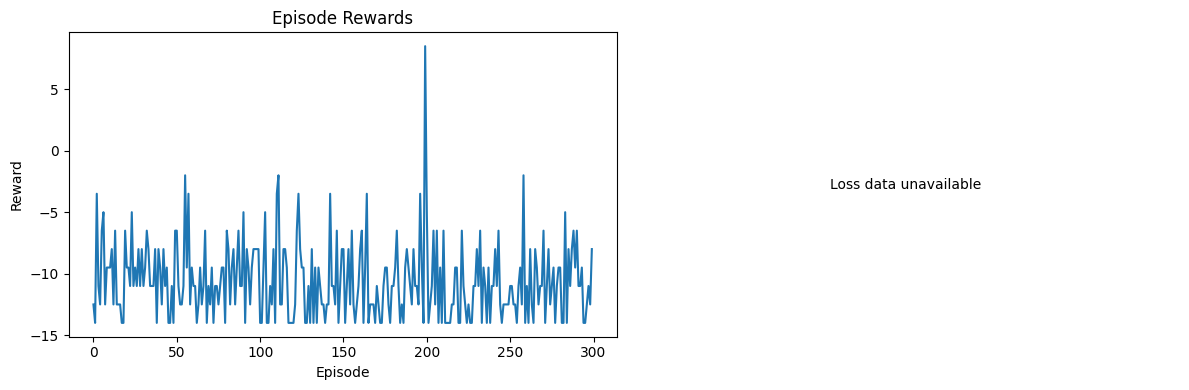

In [18]:
if training_stats is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(training_stats['rewards'])
    axes[0].set_title('Episode Rewards')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')

    if training_stats['losses']:
        axes[1].plot(training_stats['losses'])
        axes[1].set_title('Training Losses')
        axes[1].set_xlabel('Update step')
        axes[1].set_ylabel('MSE Loss')
    else:
        axes[1].text(0.5, 0.5, 'Loss data unavailable', ha='center', va='center')
        axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()
else:
    print("No training stats captured; run training to visualise curves.")

## 8. Evaluation & Diagnostics

In [19]:
def evaluate_agent(agent: DQNAgent,
                   hmm_model: CharacterHMM,
                   words: List[str],
                   games: int = 100,
                   max_lives: int = 6,
                   epsilon: float = 0.0) -> Dict[str, float]:
    env = HangmanEnv(words, hmm_model, max_lives=max_lives)
    results = []

    for _ in range(min(games, len(words))):
        state = env.reset()
        mask = env.action_mask()
        done = False
        guesses = 0
        wrong_guesses = 0
        repeat_guesses = 0

        while not done:
            action = agent.select_action(state, mask, epsilon)
            next_state, _, done, info = env.step(action)
            guesses += 1
            if info.get('repeat', False):
                repeat_guesses += 1
            elif not info.get('correct', False):
                wrong_guesses += 1
            state = next_state
            mask = env.action_mask()

        results.append({
            'success': info.get('completed', False),
            'guesses': guesses,
            'wrong_guesses': wrong_guesses,
            'repeat_guesses': repeat_guesses,
            'target_word': info.get('target_word', env.current_word)
        })

    if not results:
        return {'success_rate': 0.0}

    success_rate = np.mean([r['success'] for r in results])
    avg_guesses = np.mean([r['guesses'] for r in results])
    avg_wrong = np.mean([r['wrong_guesses'] for r in results])
    avg_repeat = np.mean([r['repeat_guesses'] for r in results])

    return {
        'success_rate': success_rate,
        'avg_guesses': avg_guesses,
        'avg_wrong_guesses': avg_wrong,
        'avg_repeat_guesses': avg_repeat,
        'samples': results[:5]
    }


def hmm_greedy_solver(word: str, hmm_model: CharacterHMM, max_lives: int = 6) -> Dict[str, object]:
    pattern = ['_'] * len(word)
    guessed = set()
    lives = max_lives
    guesses = 0
    wrong_guesses = 0

    while '_' in pattern and lives > 0:
        distribution = hmm_model.letter_distribution(''.join(pattern), guessed)
        remaining_indices = [idx for idx, char in enumerate(alphabet) if char not in guessed]
        if not remaining_indices:
            break
        best_idx = max(remaining_indices, key=lambda idx: distribution[idx])
        guess_char = alphabet[best_idx]
        guessed.add(guess_char)
        guesses += 1

        positions = [i for i, c in enumerate(word) if c == guess_char]
        if positions:
            for i in positions:
                pattern[i] = guess_char
        else:
            lives -= 1
            wrong_guesses += 1

    return {
        'success': '_' not in pattern,
        'guesses': guesses,
        'wrong_guesses': wrong_guesses,
        'final_pattern': ''.join(pattern),
        'target_word': word
    }


### 8.1 Offline Evaluation Examples

In [20]:
sampled_test_words = random.sample(test_words, k=min(50, len(test_words)))

baseline_outcomes = [hmm_greedy_solver(word, hmm) for word in sampled_test_words]
baseline_success = np.mean([res['success'] for res in baseline_outcomes])
print(f"HMM greedy baseline success on sample: {baseline_success * 100:.1f}%")

print("\nSample Viterbi decodes from blank patterns:")
for word in sampled_test_words[:5]:
    guess, score = hmm.viterbi_decode_pattern('_' * len(word), set())
    print(f"  target={word:>12} | guess={guess or 'n/a':>12} | logP={score:.2f}")

if training_stats is not None:
    eval_metrics = evaluate_agent(dqn_agent, hmm, sampled_test_words, games=len(sampled_test_words), epsilon=0.0)
    print("\nDQN Agent Evaluation Metrics:")
    for key, value in eval_metrics.items():
        if key != 'samples':
            print(f"  {key}: {value}")
    print("\nSample episodes:")
    for sample in eval_metrics['samples']:
        print(sample)
else:
    print("DQN agent not trained in this run. Train the agent to unlock RL evaluation.")

HMM greedy baseline success on sample: 10.0%

Sample Viterbi decodes from blank patterns:
  target=     spitted | guess=     pheraly | logP=-16.44
  target=   acronymic | guess=   phereraly | logP=-20.08
  target=unexplainableness | guess=pherateratereraly | logP=-34.62
  target=         gam | guess=         phy | logP=-9.30
  target=    proximal | guess=    pereraly | logP=-18.56

DQN Agent Evaluation Metrics:
  success_rate: 0.0
  avg_guesses: 8.06
  avg_wrong_guesses: 6.0
  avg_repeat_guesses: 0.0

Sample episodes:
{'success': False, 'guesses': 10, 'wrong_guesses': 6, 'repeat_guesses': 0, 'target_word': 'janet'}
{'success': False, 'guesses': 9, 'wrong_guesses': 6, 'repeat_guesses': 0, 'target_word': 'ceroplast'}
{'success': False, 'guesses': 10, 'wrong_guesses': 6, 'repeat_guesses': 0, 'target_word': 'sanctifier'}
{'success': False, 'guesses': 7, 'wrong_guesses': 6, 'repeat_guesses': 0, 'target_word': 'forehalf'}
{'success': False, 'guesses': 8, 'wrong_guesses': 6, 'repeat_guesses':

## 9. Next Steps & Optimisation Ideas
- Increase training episodes with curriculum schedules (start with shorter words, scale length) to improve convergence.
- Persist trained agent weights and reuse them between notebook sessions for quicker experimentation.
- Explore reward shaping variants (e.g., partial credit for selecting top-HMM candidates) and double DQN / dueling heads.
- Augment HMM with trigram transitions or word-level priors to tighten probability mass on coherent candidates.
- Integrate beam-search decoding for baseline solver to compare with learned policy improvements quantitatively.

In [18]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """Calculate edit distance between two strings"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]


def edits1(word: str) -> Set[str]:
    """Generate all words one edit away from word"""
    letters = string.ascii_lowercase
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    
    return set(deletes + transposes + replaces + inserts)


def edits2(word: str) -> Set[str]:
    """Generate all words two edits away from word"""
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1))


def known(words: Set[str]) -> Set[str]:
    """Filter words that exist in vocabulary"""
    return set(w for w in words if w in vocabulary)


# Test edit distance
test_pairs = [('hello', 'helo'), ('test', 'best'), ('word', 'words')]
print("Edit distances:")
for w1, w2 in test_pairs:
    print(f"  {w1} -> {w2}: {levenshtein_distance(w1, w2)}")

Edit distances:
  hello -> helo: 1
  test -> best: 1
  word -> words: 1
